In [1]:
import torch, torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device  

device(type='cuda', index=0)

In [3]:
T = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  # torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])
train_set = torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=T)
print(train_set)
test_set = torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=T)
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [4]:
BATCH_SIZE = 64
train_dl = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_set, batch_size = 1, shuffle=True)

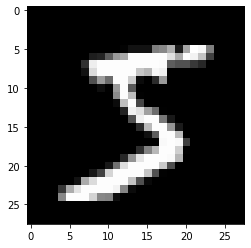

In [5]:
plt.imshow(train_set[0][0][0], cmap="gray")

# Variational Auto Encoder


In [56]:
class MNIST_VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.kl = 0
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
        )

        self.encoder_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(),
        )

        self.bottleneck1 = nn.Linear(128, 2)
        self.bottleneck2 = nn.Linear(128, 2)

        self.decoder_dense = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 3*3*32),
            nn.ReLU(),
            nn.Unflatten(1, [32, 3, 3])
        )

        self.decoder_maxunpool = nn.MaxUnpool2d(2)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoder_conv = self.encoder_conv(x)
        encoder_dense = self.encoder_dense(encoder_conv)

        mu = self.bottleneck1(encoder_dense)
        sigma = torch.exp(self.bottleneck2(encoder_dense))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        decoder_dense = self.decoder_dense(z)
        decoder_conv = self.decoder_conv(decoder_dense)
        return decoder_conv, z


In [75]:
vae = MNIST_VAE()
print(vae.eval())

MNIST_VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (encoder_dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=128, bias=True)
    (2): ReLU()
  )
  (bottleneck1): Linear(in_features=128, out_features=2, bias=True)
  (bottleneck2): Linear(in_features=128, out_features=2, bias=True)
  (decoder_dense): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=[32, 

  0%|          | 0/50 [00:00<?, ?it/s]

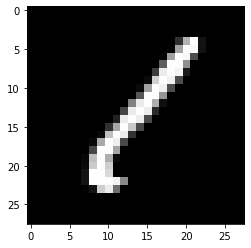

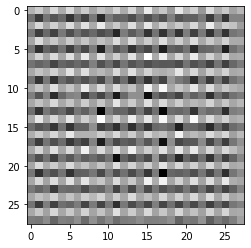

938it [00:32, 29.27it/s]
  2%|▏         | 1/50 [00:32<26:10, 32.05s/it]

3768.245703463361


938it [00:29, 32.31it/s]
  4%|▍         | 2/50 [01:01<24:13, 30.28s/it]

2766.538572396805


938it [00:29, 31.90it/s]
  6%|▌         | 3/50 [01:30<23:24, 29.88s/it]

2642.5057742641425


938it [00:29, 31.64it/s]
  8%|▊         | 4/50 [02:00<22:50, 29.79s/it]

2579.72008158149


938it [00:31, 30.00it/s]
 10%|█         | 5/50 [02:31<22:44, 30.32s/it]

2547.034027945512


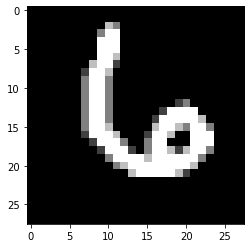

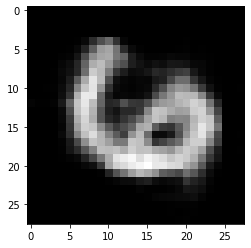

938it [00:29, 31.37it/s]
 12%|█▏        | 6/50 [03:01<22:07, 30.18s/it]

2520.951984983009


938it [00:29, 32.01it/s]
 14%|█▍        | 7/50 [03:30<21:25, 29.90s/it]

2500.9156023037713


938it [00:30, 31.26it/s]
 16%|█▌        | 8/50 [04:00<20:57, 29.93s/it]

2481.710273401061


938it [00:29, 31.30it/s]
 18%|█▊        | 9/50 [04:30<20:27, 29.95s/it]

2466.841153988706


938it [00:30, 31.18it/s]
 20%|██        | 10/50 [05:00<19:59, 29.99s/it]

2454.0290609331273


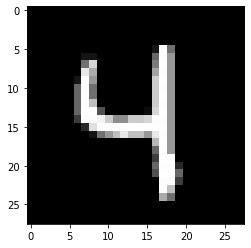

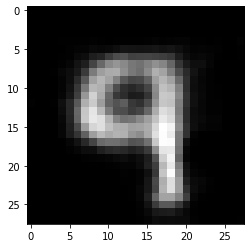

938it [00:30, 30.81it/s]
 22%|██▏       | 11/50 [05:31<19:35, 30.13s/it]

2442.8603442747203


938it [00:32, 28.50it/s]
 24%|██▍       | 12/50 [06:04<19:37, 30.98s/it]

2431.0650807850398


938it [00:30, 30.58it/s]
 26%|██▌       | 13/50 [06:34<19:02, 30.89s/it]

2420.9941726391758


938it [00:30, 30.81it/s]
 28%|██▊       | 14/50 [07:05<18:27, 30.76s/it]

2412.6508429879063


938it [00:35, 26.07it/s]
 30%|███       | 15/50 [07:41<18:51, 32.33s/it]

2404.432550686509


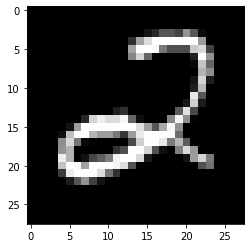

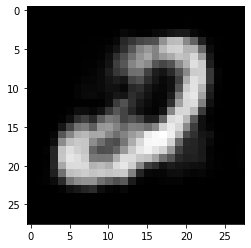

938it [00:36, 25.76it/s]
 32%|███▏      | 16/50 [08:17<19:01, 33.56s/it]

2397.9904233367206


938it [00:33, 28.38it/s]
 34%|███▍      | 17/50 [08:50<18:22, 33.41s/it]

2388.9282734104313


938it [00:30, 31.18it/s]
 36%|███▌      | 18/50 [09:20<17:17, 32.41s/it]

2382.2709444285965


938it [00:30, 30.71it/s]
 38%|███▊      | 19/50 [09:51<16:27, 31.85s/it]

2377.0478705627834


938it [00:29, 31.81it/s]
 40%|████      | 20/50 [10:20<15:34, 31.14s/it]

2371.9244576069846


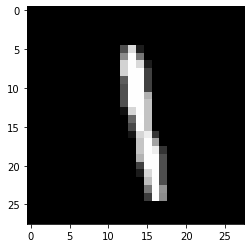

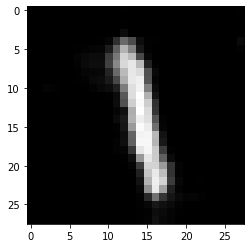

938it [00:35, 26.58it/s]
 42%|████▏     | 21/50 [10:56<15:39, 32.39s/it]

2365.9625071055852


938it [00:36, 25.89it/s]
 44%|████▍     | 22/50 [11:32<15:39, 33.55s/it]

2361.0226238714354


938it [00:27, 33.62it/s]
 46%|████▌     | 23/50 [12:00<14:20, 31.85s/it]

2356.3292784213004


938it [00:26, 35.43it/s]
 48%|████▊     | 24/50 [12:26<13:06, 30.24s/it]

2350.6582221252834


938it [00:29, 32.15it/s]
 50%|█████     | 25/50 [12:55<12:28, 29.92s/it]

2347.2782352016425


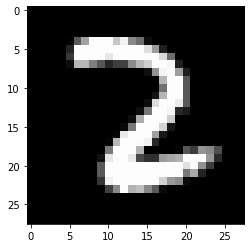

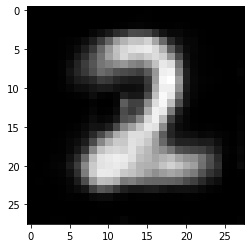

938it [00:27, 34.04it/s]
 52%|█████▏    | 26/50 [13:23<11:41, 29.21s/it]

2344.4503297460105


938it [00:30, 30.73it/s]
 54%|█████▍    | 27/50 [13:53<11:20, 29.61s/it]

2341.9378714164945


938it [00:33, 27.90it/s]
 56%|█████▌    | 28/50 [14:27<11:17, 30.81s/it]

2337.0125330292594


938it [00:33, 28.31it/s]
 58%|█████▊    | 29/50 [15:00<11:01, 31.51s/it]

2334.451259393428


938it [00:28, 32.57it/s]
 60%|██████    | 30/50 [15:29<10:13, 30.70s/it]

2332.3451277808085


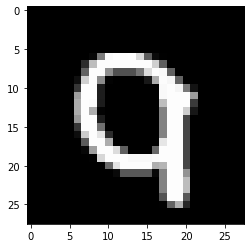

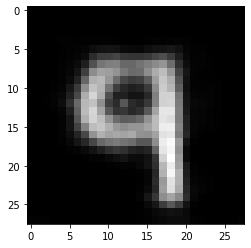

938it [00:27, 34.65it/s]
 62%|██████▏   | 31/50 [15:56<09:22, 29.61s/it]

2329.2229434666096


938it [00:27, 33.60it/s]
 64%|██████▍   | 32/50 [16:24<08:43, 29.11s/it]

2326.461959480985


938it [00:31, 29.94it/s]
 66%|██████▌   | 33/50 [16:55<08:26, 29.77s/it]

2324.9828564088734


938it [00:30, 30.86it/s]
 68%|██████▊   | 34/50 [17:26<07:59, 29.96s/it]

2319.0719240103194


938it [00:27, 34.18it/s]
 70%|███████   | 35/50 [17:53<07:18, 29.21s/it]

2318.61829732476


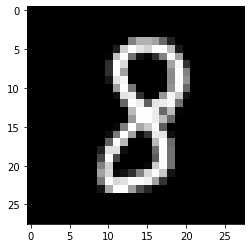

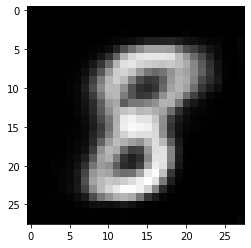

938it [00:27, 34.70it/s]
 72%|███████▏  | 36/50 [18:20<06:39, 28.56s/it]

2316.8400445543625


938it [00:28, 33.15it/s]
 74%|███████▍  | 37/50 [18:49<06:10, 28.48s/it]

2313.9481713919245


938it [00:34, 27.14it/s]
 76%|███████▌  | 38/50 [19:23<06:03, 30.31s/it]

2311.8728966946796


938it [00:30, 30.83it/s]
 78%|███████▊  | 39/50 [19:54<05:33, 30.34s/it]

2310.742178780692


938it [00:27, 33.77it/s]
 80%|████████  | 40/50 [20:21<04:55, 29.57s/it]

2310.2350275165745


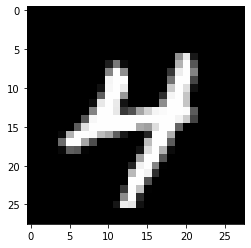

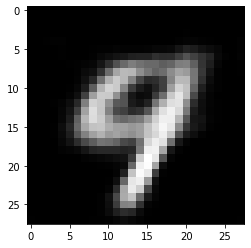

938it [00:29, 31.95it/s]
 82%|████████▏ | 41/50 [20:51<04:25, 29.51s/it]

2307.8235716992604


938it [00:31, 29.93it/s]
 84%|████████▍ | 42/50 [21:22<04:00, 30.06s/it]

2304.7545357319846


938it [00:30, 31.18it/s]
 86%|████████▌ | 43/50 [21:52<03:30, 30.07s/it]

2304.3561354517174


938it [00:32, 28.66it/s]
 88%|████████▊ | 44/50 [22:25<03:05, 30.87s/it]

2302.5099022708723


938it [00:31, 29.62it/s]
 90%|█████████ | 45/50 [22:57<02:35, 31.11s/it]

2297.594545409115


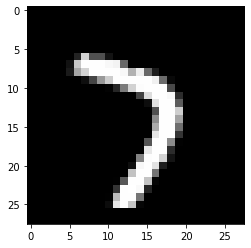

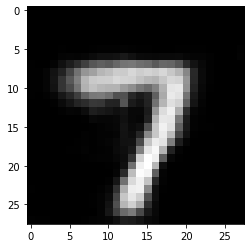

938it [00:28, 32.99it/s]
 92%|█████████▏| 46/50 [23:25<02:01, 30.31s/it]

2302.1467316389594


938it [00:31, 29.73it/s]
 94%|█████████▍| 47/50 [23:57<01:32, 30.68s/it]

2299.872214376291


938it [00:32, 28.89it/s]
 96%|█████████▌| 48/50 [24:29<01:02, 31.22s/it]

2297.809984414562


938it [00:31, 30.04it/s]
 98%|█████████▊| 49/50 [25:00<00:31, 31.22s/it]

2295.656078086479


938it [00:35, 26.61it/s]
100%|██████████| 50/50 [25:35<00:00, 30.72s/it]

2295.14256602208


In [76]:
torch.manual_seed(42)

EPOCHS = 50
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in tqdm(enumerate(train_dl)):
    images = images.to(device)
    labels = labels.to(device)
    pred, bottlenecked = vae(images)

    #DISPLAY IMAGE
    if j == 0 and i % 5 == 0:
      plt.imshow(torch.squeeze(images)[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(torch.squeeze(pred[0])).detach().numpy(), cmap = "gray")
      plt.show()

    #MSE
    loss = ((images - pred)**2).sum() + vae.kl
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
  print(sum_loss/ctr)

torch.save(vae, "vae.pt")

In [77]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
       _, encoded_img  = vae(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [00:42<00:00, 233.55it/s]
